In [21]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warning for chained assignments
import numpy as np
import scipy
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='white', font_scale=1.5)  # Set seaborn style and font scale
import control
import statsmodels
import statsmodels.formula.api as smf

# Import custom modules
import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [22]:
# Create instances of the Modelling, Statistics, PrepEmotioncon, and Auxiliary classes
emo = emotioncon_modelling.Modelling() 
emostats = emotioncon_stats.Statistics() 
prep = prep_emotioncon.PrepEmotioncon()  
aux = auxiliary.Auxiliary()

attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])  # Define the attention check criteria as an array
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']  # Define the mood categories as a list
group_label = ['control', 'distancing'] # Define the group label as a list
filepath = '../'  # Specify the file path
debug = True  # Flag FALSE to save files and figures
palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"} # Define color palette

In [23]:
# Load data from a numpy file
data = np.load(filepath + 'results/fit_experiment.npy', allow_pickle=True)

# Process the loaded data into a DataFrame, mood ratings, and other related variables
df, mood_ratings, foo = prep.create_df_from_dict(data)

# Create inputs based on videos shown during experiment
inp = emo.input_from_videos('../experiment/public/prep/videosForExperiment.csv')

# Calculate the number of subjects based on the length of the loaded data
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


Exclude outliers
--

Excluded subjects trajectories:
group: 1.0


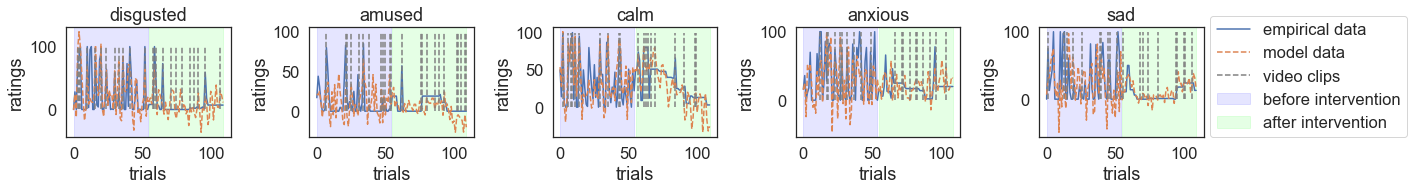

group: 0.0


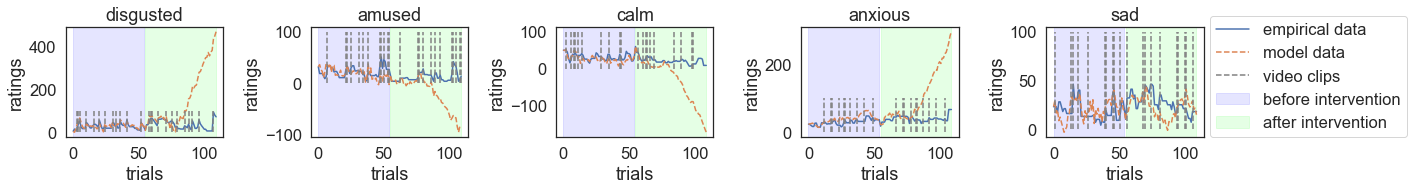

group: 1.0


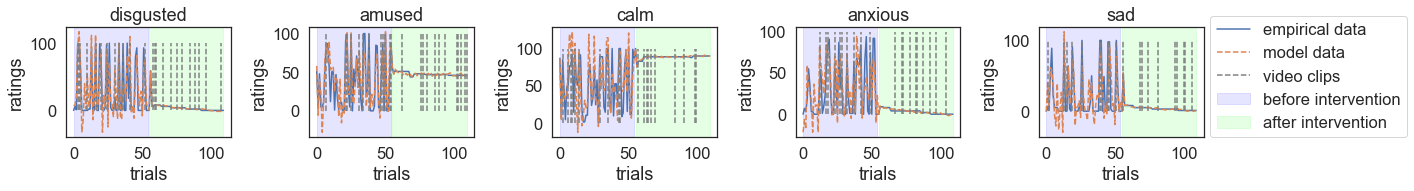

group: 1.0


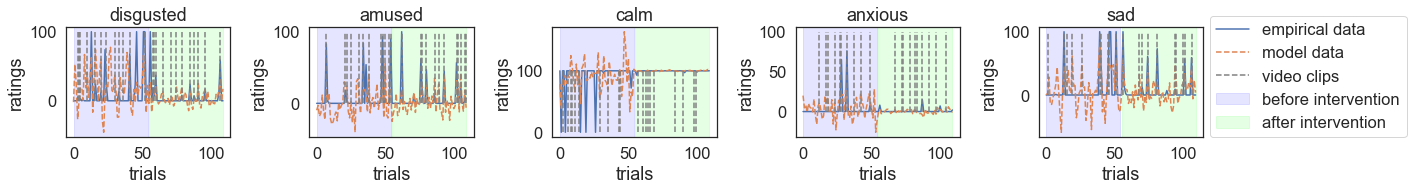

Final sample N = 104; thereof in distancing group: 54.0


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:199: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:, sj, k] = np.log(0.5) / np.log(e)


In [24]:
# Exclude participants if their estimates show outliers
ex = emostats.exclude_outliers(data, 13, 14, 'results_split')

# Plot excluded case
print('Excluded subjects trajectories:')
T = np.shape(data[0]['ratings'])[1]
for sj in ex[0]:
    # Print the group of the excluded subject
    print('group: ' + str(df['randomized_condition'][sj]))
    
    # Plot the simulated data of the excluded subject
    emo.plot_simulated_data(data[sj], inp, mood_categories)

# Update the data array by deleting the excluded subjects
data = np.delete(data, ex[0])
Nsj = len(data)

# Recalculate DataFrame, mood ratings, and other variables using the updated data
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)

# Print the final sample size and the number of participants in the distancing group
print('Final sample N = ' + str(Nsj) + '; thereof in distancing group: ' \
      + str(df['randomized_condition'].sum()))

np.save(filepath + 'results/fit_experiment_included.npy', data)

Statistics of Dynamics and Controllability Features
--

Group comparison of input weight matrix and controllability Gramian norm
--

In [5]:
# Loop over subjects
for i in range(Nsj):
    # Loop over before and after
    for t in range(2):
        # Calculate the L2 norm of the 'matrix' in 'controls' and store it in the DataFrame 'df'
        df.loc[i, 'c_norm' + str(t)] = np.linalg.norm(controls['matrix'][:,:,i, t])
        
        # Calculate the L2 norm of the controllability matrix using 'dynamics' and 'controls' matrices,
        # and store it in the DataFrame 'df'
        df.loc[i, 'gramian_norm' + str(t)] = np.linalg.norm(control.ctrb(dynamics['matrix'][:,:,i,t], \
                                                                         controls['matrix'][:,:,i,t]))

# Create a new DataFrame to store the results of matrix norms
df_matrix_norms = pd.DataFrame()

# Loop over two types of norms: 'c_norm' and 'gramian_norm'
for j in ['c_norm', 'gramian_norm']:
    # Loop over two iterations: 0 for 'before' and 1 for 'after'
    for i in range(2):
        # Calculate the mean and standard deviation of the matrix norms for each 'randomized_condition'
        df_grouped = df[[j + str(i), 'randomized_condition']].groupby(['randomized_condition'])
        mean_std = df_grouped.mean().round().astype(str) + '±' + df_grouped.std().round().astype(str)
        
        # Store the calculated mean and standard deviation in the 'df_matrix_norms' DataFrame
        df_matrix_norms[j + ['_before', '_after'][i]] = mean_std
        
        # Perform Mann-Whitney U test to compare the matrix norms between 'randomized_condition' 0 and 1
        tstats = scipy.stats.mannwhitneyu(df[j  + str(i)][df['randomized_condition']==0], \
                                          df[j + str(i)][df['randomized_condition']==1])
        
        # Store the result of the Mann-Whitney U test in the 'df_matrix_norms' DataFrame
        df_matrix_norms[j + '_stats' + ['_before', '_after'][i]] = np.round(tstats,3)

# Output the final 'df_matrix_norms' DataFrame containing the matrix norms and statistical test results
df_matrix_norms

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/control/statesp.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


,c_norm_before,c_norm_stats_before,c_norm_after,c_norm_stats_after,gramian_norm_before,gramian_norm_stats_before,gramian_norm_after,gramian_norm_stats_after
randomized_condition,,,,,,,,
0.0,351.0±207.0,1624.000,400.0±224.0,1897.0,452.0±297.0,1605.000,509.0±295.0,1851.000
1.0,280.0±185.0,0.075,256.0±220.0,0.0,350.0±236.0,0.098,335.0±287.0,0.001


Group comparison of eigenspectra of dynamics matrix and controllability
--

In [6]:
# Define the labels for stability and controllability
label = ['stability', 'controllability']

# Loop over dynamics and controls data
for k, p in enumerate([dynamics, controls]):
    # Print label and section header for stability or controllability
    print(20 * '#' + '\n' + label[k] + ':')
    mm = []  # Initialize an empty list to store the median and standard deviation data
    
    # Print section header for eigenvectors
    print('eigenvectors')
    
    # Loop over the randomized_condition (0 and 1)
    for i in range(2):
        # Calculate the median and standard deviation of the absolute values of eigenvectors for each condition
        mm.append(np.nanmedian(p['absvec'][:, 0, df['randomized_condition'] == i, 0], axis=1))
        mm.append(np.nanstd(p['absvec'][:, 0, df['randomized_condition'] == i, 0], axis=1))
    
    # Create a new DataFrame 'df_new' with the calculated median and standard deviation data for eigenvectors
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = mood_categories
    
    # Display the DataFrame containing eigenvector statistics
    display(df_new)

    mm = []  # Reset the 'mm' list for storing eigenvalue statistics
    
    # Print section header for eigenvalues
    print('eigenvalues')
    
    # Loop over the randomized_condition (0 and 1)
    for i in range(2):
        # Calculate the real part of median and standard deviation of eigenvalues for each condition
        mm.append(np.real(np.nanmedian(p['val'][:, df['randomized_condition'] == i, 0], axis=1)))
        mm.append(np.real(np.nanstd(p['val'][:, df['randomized_condition'] == i, 0], axis=1)))
    
    # Create a new DataFrame 'df_new' with the calculated median and standard deviation data for eigenvalues
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = [[str(i + 1) + '.' for i in range(5)]]
    
    # Display the DataFrame containing eigenvalue statistics
    display(df_new)


####################
stability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.289026,0.221231,0.352335,0.224406
amused,0.284710,0.207946,0.187649,0.234791
calm,0.408657,0.259305,0.506473,0.270561
anxious,0.446264,0.201370,0.398563,0.250439
sad,0.333082,0.189583,0.274880,0.228302


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,0.572744,0.219604,0.666610,0.218977
2.,0.334350,0.204017,0.379253,0.244266
3.,0.144213,0.211921,0.237962,0.254231
4.,0.026278,0.167655,0.049844,0.217771
5.,-0.104968,0.218485,-0.068845,0.195988


####################
controllability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.513069,0.239955,0.468206,0.228285
amused,0.351798,0.213500,0.325070,0.204921
calm,0.361920,0.203514,0.409205,0.219230
anxious,0.458846,0.204059,0.331523,0.234032
sad,0.350438,0.181624,0.386450,0.200001


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,369.353011,298.975479,275.456361,238.229139
2.,99.820707,34.885287,84.702852,42.157509
3.,58.673237,18.052122,45.708520,21.532203
4.,36.615825,15.764173,27.189685,14.971249
5.,19.201210,13.828224,14.043060,12.580723


In [7]:
# Compare dominant eigenvalue of stability & controllability after intervention

# Output the final 'df_matrix_eigval' DataFrame containing eigenvalues and statistical test results
df_matrix_eigval = pd.DataFrame()

for j, i in enumerate([dynamics, controls]):
    dd = np.abs(i['val'][0,:,1])
    tstats = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                      dd[df['randomized_condition']==1])
    
    for g in range(2):
        # Store the mean and std in the 'df_matrix_eigval' DataFrame
        df_matrix_eigval.loc[g,['dynamics', 'control'][j]] = \
        str(np.round(np.mean([dd[df['randomized_condition']==g]]),2)) + '±' \
        + str(np.round(np.std([dd[df['randomized_condition']==g]]),2))

     # Store the result of the Mann-Whitney U test in the 'df_matrix_eigval' DataFrame
    df_matrix_eigval[['dynamics', 'control'][j] + '_stats'] = np.round(tstats,3)

df_matrix_eigval

,dynamics,dynamics_stats,control,control_stats
0,0.52±0.22,762.0,482.27±294.09,1844.000
1,0.69±0.21,0.0,313.53±283.36,0.001


In [8]:
# Compare first eigenvector of controllability & stability after intervention using Hotelling T2-test

df_stats_both = pd.DataFrame()
for j, i in enumerate([dynamics, controls]):
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i['absvec'][:,0,:,:], df)
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)
    
df_stats_both.columns = [list(np.repeat(label,3)), list(df_stats_both.columns.values)]
display(df_stats_both)

stability               controllability         \
                               T2 Fstats pvalue              T2 Fstats   
before intervention          7.20   1.38  0.237            3.69   0.71   
after intervention          14.81   2.85  0.019           24.67   4.74   
change (after - before)      1.21   0.23  0.948           17.45   3.35   

                                  
                          pvalue  
before intervention        0.618  
after intervention       < 0.001  
change (after - before)    0.008

In [9]:
# Interaction effect on first eigenvector of controllability & stability using MANOVA
from statsmodels.multivariate.manova import MANOVA

# Loop over dynamics and controls
for j, p in enumerate([dynamics, controls]):
    # Print label for each iteration
    print(label[j])
    
    # Create an empty DataFrame to store data for MANOVA
    df_test = pd.DataFrame()
    
    # Loop over t values (0 and 1)
    for t in range(2):
        # Concatenate data from 'p' DataFrame to 'df_test'
        df_test = pd.concat((df_test, pd.DataFrame(p['absvec'][:, 0, :, t])), axis=1, ignore_index=True)
    
    # Transpose the DataFrame and set column names to mood_categories
    df_test = df_test.T
    df_test.columns = mood_categories
    
    # Add 'time' and 'condition' columns to 'df_test'
    df_test['time'] = np.concatenate((np.zeros([Nsj, 1]), np.ones([Nsj, 1])))
    df_test['condition'] = np.concatenate((df['randomized_condition'].values, df['randomized_condition'].values))
    
    # Perform MANOVA test with 'disgusted', 'amused', 'calm', 'anxious', and 'sad' as dependent variables
    # and 'condition' and 'time' as independent variables
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition * time', data=df_test)
    
    # Display the MANOVA summary frame
    display(fit.mv_test().summary_frame)

stability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                     
Intercept      Wilks' lambda             0.07326      5  200.0  506.000648   
               Pillai's trace            0.92674    5.0  200.0  506.000648   
               Hotelling-Lawley trace  12.650016      5  200.0  506.000648   
               Roy's greatest root     12.650016      5    200  506.000648   
condition      Wilks' lambda            0.966633      5  200.0    1.380739   
               Pillai's trace           0.033367    5.0  200.0    1.380739   
               Hotelling-Lawley trace   0.034518      5  200.0    1.380739   
               Roy's greatest root      0.034518      5    200    1.380739   
time           Wilks' lambda            0.994426      5  200.0    0.224226   
               Pillai's trace           0.005574    5.0  200.0    0.224226   
               Hotelling-Lawley trace   0.005606      5  200.0    0.224226   
               Roy's greatest root      0.005606      5    200    0.224226   
condition:time Wilks' lambda            0.995512      5  200.0    0.180323   
               Pillai's trace           0.004488    5.0  200.0    0.180323   
               Hotelling-Lawley trace   0.004508      5  200.0    0.180323   
               Roy's greatest root      0.004508      5    200    0.180323   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.232983  
               Pillai's trace          0.232983  
               Hotelling-Lawley trace  0.232983  
               Roy's greatest root     0.232983  
time           Wilks' lambda           0.951744  
               Pillai's trace          0.951744  
               Hotelling-Lawley trace  0.951744  
               Roy's greatest root     0.951744  
condition:time Wilks' lambda           0.969763  
               Pillai's trace          0.969763  
               Hotelling-Lawley trace  0.969763  
               Roy's greatest root     0.969763

controllability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                    
Intercept      Wilks' lambda           0.046706      5  200.0  816.412013   
               Pillai's trace          0.953294    5.0  200.0  816.412013   
               Hotelling-Lawley trace   20.4103      5  200.0  816.412013   
               Roy's greatest root      20.4103      5    200  816.412013   
condition      Wilks' lambda           0.985749      5  200.0    0.578296   
               Pillai's trace          0.014251    5.0  200.0    0.578296   
               Hotelling-Lawley trace  0.014457      5  200.0    0.578296   
               Roy's greatest root     0.014457      5    200    0.578296   
time           Wilks' lambda           0.945363      5  200.0    2.311774   
               Pillai's trace          0.054637    5.0  200.0    2.311774   
               Hotelling-Lawley trace  0.057794      5  200.0    2.311774   
               Roy's greatest root     0.057794      5    200    2.311774   
condition:time Wilks' lambda           0.941096      5  200.0    2.503619   
               Pillai's trace          0.058904    5.0  200.0    2.503619   
               Hotelling-Lawley trace   0.06259      5  200.0    2.503619   
               Roy's greatest root      0.06259      5    200    2.503619   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.716598  
               Pillai's trace          0.716598  
               Hotelling-Lawley trace  0.716598  
               Roy's greatest root     0.716598  
time           Wilks' lambda           0.045377  
               Pillai's trace          0.045377  
               Hotelling-Lawley trace  0.045377  
               Roy's greatest root     0.045377  
condition:time Wilks' lambda            0.03174  
               Pillai's trace           0.03174  
               Hotelling-Lawley trace   0.03174  
               Roy's greatest root      0.03174

In [10]:
# Statistic table making group comparisons of single eigenvector loadings 
# 1) within group
# 2) between group before and after

# Print the significance level for multiple comparison correction
print('multiple comparison: ' + str(0.05/15))

# Initialize an empty DataFrame to store statistical results
df_stats = pd.DataFrame()

# Loop over 'dynamics' and 'controls' to perform statistical tests
for j in [dynamics['absvec'][:, 0, :, :], controls['absvec'][:, 0, :, :]]:
    # Initialize arrays to store p-values, statistics, and means with standard deviations
    pval, statistics = [np.empty((4, 5)) for i in range(2)]
    mm1, mm2 = [np.empty((4, 5), dtype=object) for i in range(2)]

    # Loop over time points (0 and 1) for group comparison
    for t in range(2):
        for i in range(5):
            dd = j[i, :, t]
            # Perform Mann-Whitney U test for group comparison
            statistics[t, i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition'] == 0], dd[df['randomized_condition'] == 1]).statistic
            pval[t, i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition'] == 0], dd[df['randomized_condition'] == 1]).pvalue
            mm1[t, i] = str((np.round(np.nanmean(dd[df['randomized_condition'] == 0]), 2))) + '$\pm$' + \
                        str((np.round(np.nanstd(dd[df['randomized_condition'] == 0]), 2)))
            mm2[t, i] = str((np.round(np.nanmean(dd[df['randomized_condition'] == 1]), 2))) + '$\pm$' + \
                        str((np.round(np.nanstd(dd[df['randomized_condition'] == 1]), 2)))

    # Loop over conditions (0 and 1) for before-after comparison
    for g in range(2):
        for i in range(5):
            dd = j[i, :, :]
            # Perform Wilcoxon test for before-after comparison
            statistics[g + 2, i] = scipy.stats.wilcoxon(dd[df['randomized_condition'] == g, 0], dd[df['randomized_condition'] == g, 1]).statistic
            pval[g + 2, i] = scipy.stats.wilcoxon(dd[df['randomized_condition'] == g, 0], dd[df['randomized_condition'] == g, 1]).pvalue
            mm1[g + 2, i] = str((np.round(np.nanmean(dd[df['randomized_condition'] == g, 0]), 2))) + '$\pm$' + \
                           str((np.round(np.nanstd(dd[df['randomized_condition'] == g, 0]), 2)))
            mm2[g + 2, i] = str((np.round(np.nanmean(dd[df['randomized_condition'] == g, 1]), 2))) + '$\pm$' + \
                           str((np.round(np.nanstd(dd[df['randomized_condition'] == g, 1]), 2)))

    # Prepare a 2D array with mean and standard deviation values, statistics, and p-values
    statsarray = np.empty((4, 20), dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i, j * 4] = mm1[i, j]
            statsarray[i, j * 4 + 1] = mm2[i, j]
            statsarray[i, j * 4 + 2] = np.round(statistics[i, j], 2)
            if pval[i, j] < 0.001:
                statsarray[i, j * 4 + 3] = '$<$0.001'
            else:
                statsarray[i, j * 4 + 3] = np.round(pval[i, j], 3)

    # Prepare the header for the DataFrame
    header = [np.repeat(mood_categories, 4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', 'statistics', 'pvalue']]
    
    # Concatenate the statistical results into 'df_stats' DataFrame
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1', \
                            'before vs after g=0', 'before vs after g=1'], columns=header)))

# Set index names for hierarchical indexing
df_stats.index = [np.repeat(['stability', 'controllability'], 4), df_stats.index]

# Round the values in the DataFrame to 2 decimal places
df_stats.round(2)

# Uncomment the code below if you want to print the DataFrame as a LaTeX table
# print(df_stats.round(2).to_latex(escape=False))

multiple comparison: 0.0033333333333333335


disgusted                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0  0.34$\pm$0.22  0.36$\pm$0.22   
                group comparison t=1     0.35$\pm$0.19  0.34$\pm$0.25   
                before vs after g=0      0.34$\pm$0.22  0.35$\pm$0.19   
                before vs after g=1      0.36$\pm$0.22  0.34$\pm$0.25   
controllability group comparison at t=0  0.48$\pm$0.24  0.47$\pm$0.23   
                group comparison t=1     0.49$\pm$0.21  0.41$\pm$0.24   
                before vs after g=0      0.48$\pm$0.24  0.49$\pm$0.21   
                before vs after g=1      0.47$\pm$0.23  0.41$\pm$0.24   

                                                                  amused  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1313.0  0.812  0.34$\pm$0.21   
                group comparison t=1        1422.0  0.642  0.33$\pm$0.24   
                before vs after g=0          610.0  0.791  0.34$\pm$0.21   
                before vs after g=1          701.0  0.721  0.29$\pm$0.23   
controllability group comparison at t=0     1371.0  0.894  0.36$\pm$0.21   
                group comparison t=1        1588.0  0.122  0.27$\pm$0.21   
                before vs after g=0          632.0  0.958  0.36$\pm$0.21   
                before vs after g=1          580.0  0.162   0.36$\pm$0.2   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.29$\pm$0.23     1632.0  0.067   
                group comparison t=1     0.26$\pm$0.23     1633.0  0.066   
                before vs after g=0      0.33$\pm$0.24      603.0  0.739   
                before vs after g=1      0.26$\pm$0.23      618.0  0.284   
controllability group comparison at t=0   0.36$\pm$0.2     1358.0  0.961   
                group comparison t=1     0.31$\pm$0.24     1252.0  0.526   
                before vs after g=0      0.27$\pm$0.21      398.0  0.021   
                before vs after g=1      0.31$\pm$0.24      616.0  0.276   

                                                  calm                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0  0.39$\pm$0.26  0.47$\pm$0.27   
                group comparison t=1     0.41$\pm$0.23  0.54$\pm$0.25   
                before vs after g=0      0.39$\pm$0.26  0.41$\pm$0.23   
                before vs after g=1      0.47$\pm$0.27  0.54$\pm$0.25   
controllability group comparison at t=0   0.37$\pm$0.2  0.41$\pm$0.22   
                group comparison t=1       0.3$\pm$0.2  0.47$\pm$0.29   
                before vs after g=0       0.37$\pm$0.2    0.3$\pm$0.2   
                before vs after g=1      0.41$\pm$0.22  0.47$\pm$0.29   

                                                                 anxious  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1136.0  0.165   0.43$\pm$0.2   
                group comparison t=1        1006.0  0.025  0.38$\pm$0.24   
                before vs after g=0          590.0  0.647   0.43$\pm$0.2   
                before vs after g=1          590.0  0.189  0.38$\pm$0.25   
controllability group comparison at t=0     1234.0  0.452   0.41$\pm$0.2   
                group comparison t=1         874.0  0.002  0.39$\pm$0.23   
                before vs after g=0          415.0  0.032   0.41$\pm$0.2   
                before vs after g=1          586.0  0.178  0.34$\pm$0.23   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.38$\pm$0.25     1513.0   0.29   
                group comparison t=1     0.32$\pm$0.26     1575.0  0.144

In [11]:
def mean_std_annotation(data: np.array, group: bool) -> np.array:
    a = np.round(np.nanmean(np.real(data[:,:,group]),axis=2),2).astype(str)
    b = np.round(np.nanstd(np.real(data[:,:,group]),axis=2),2).astype(str)
    annotation = np.array(a,dtype=np.object_) + ' ±\n ' + np.array(b,dtype=np.object_)
    return annotation

def plot_matrices(controls: dict, dynamics: dict, group: int, mood_categories: list):
    """
    Plot matrices for control and dynamics.
    Args:
        controls (dict): Control data.
        dynamics (dict): Dynamics data.
        group (int): Group index.
        mood_categories (list): Mood categories.
    Returns:
        None.
    """
    fig, axs = plt.subplots(3,2, figsize=[15,15])
    timepoint = ['before', 'after']
    parameter = ['control', 'dynamics']
    par = [controls['matrix'], dynamics['matrix']]
    annotation = np.full_like(controls['matrix'][:,:,0,0], np.nan)
    for j, p in enumerate(np.real(par)):
        for i in range(2):
            vmin = np.nanmean(p[:,:,group,:],axis=2).min()
            vmax = np.nanmean(p[:,:,group,:],axis=2).max()
            annotation = mean_std_annotation(p[:,:,:,i], group)
            sns.heatmap(np.nanmean(p[:,:,group,i],axis=2),ax=axs[i,j], \
                        annot=annotation, fmt='', annot_kws={"fontsize":12}, \
                        vmin=vmin, vmax=vmax, xticklabels=mood_categories, yticklabels=mood_categories)
            axs[i,j].set_title(parameter[j] + ' ' + timepoint[i])

        annotation = mean_std_annotation(p[:,:,:,1] - p[:,:,:,0], group)
        sns.heatmap(np.real(np.nanmean(p[:,:,group,1] - p[:,:,group,0], axis=2)), \
                    annot=annotation, fmt='', annot_kws={"fontsize":12}, \
                    xticklabels=mood_categories, yticklabels=mood_categories, ax=axs[2,j])
        axs[2,j].set_title(parameter[j] + ' after - before')
    plt.tight_layout()

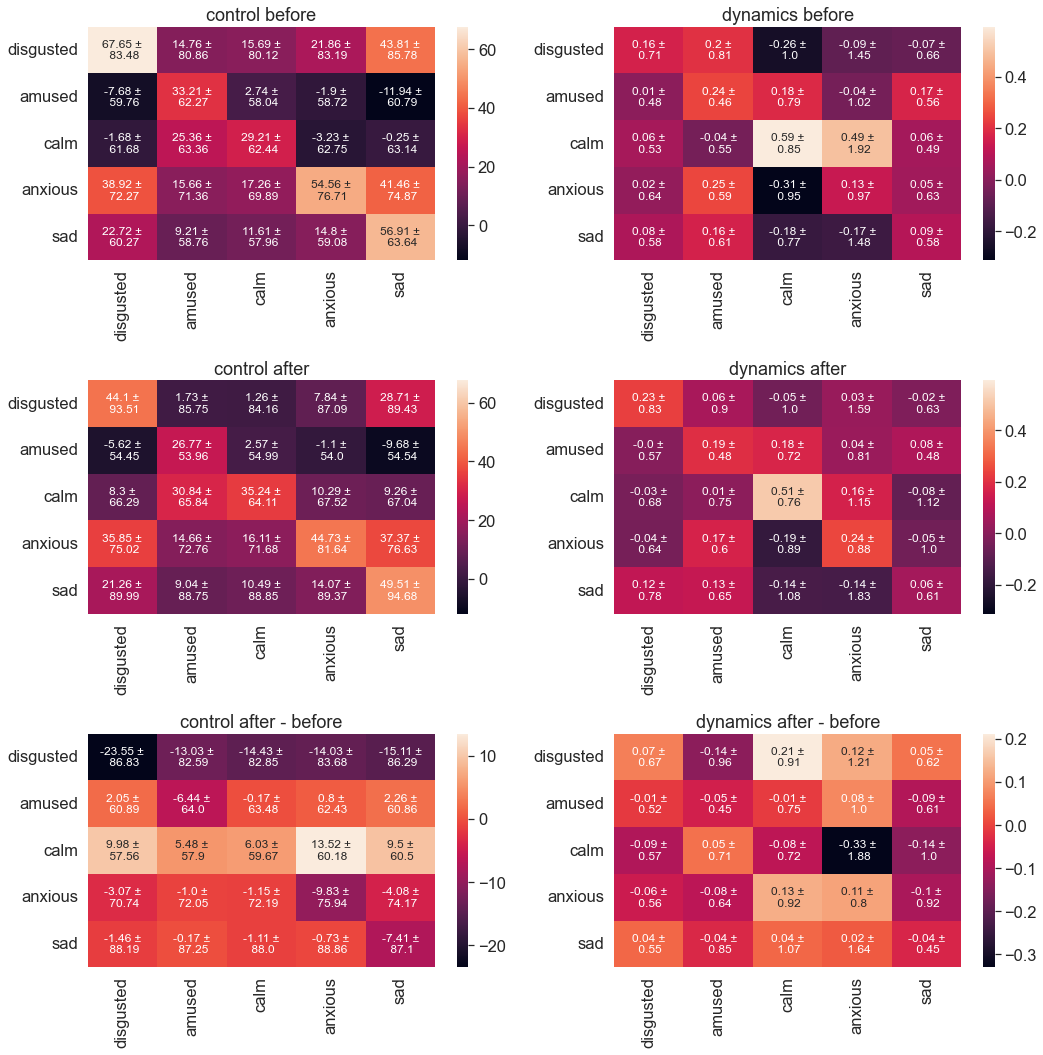

In [12]:
# Average dynamics and control matrix all participants
plot_matrices(controls, dynamics, np.ones(len(df))==1, mood_categories)

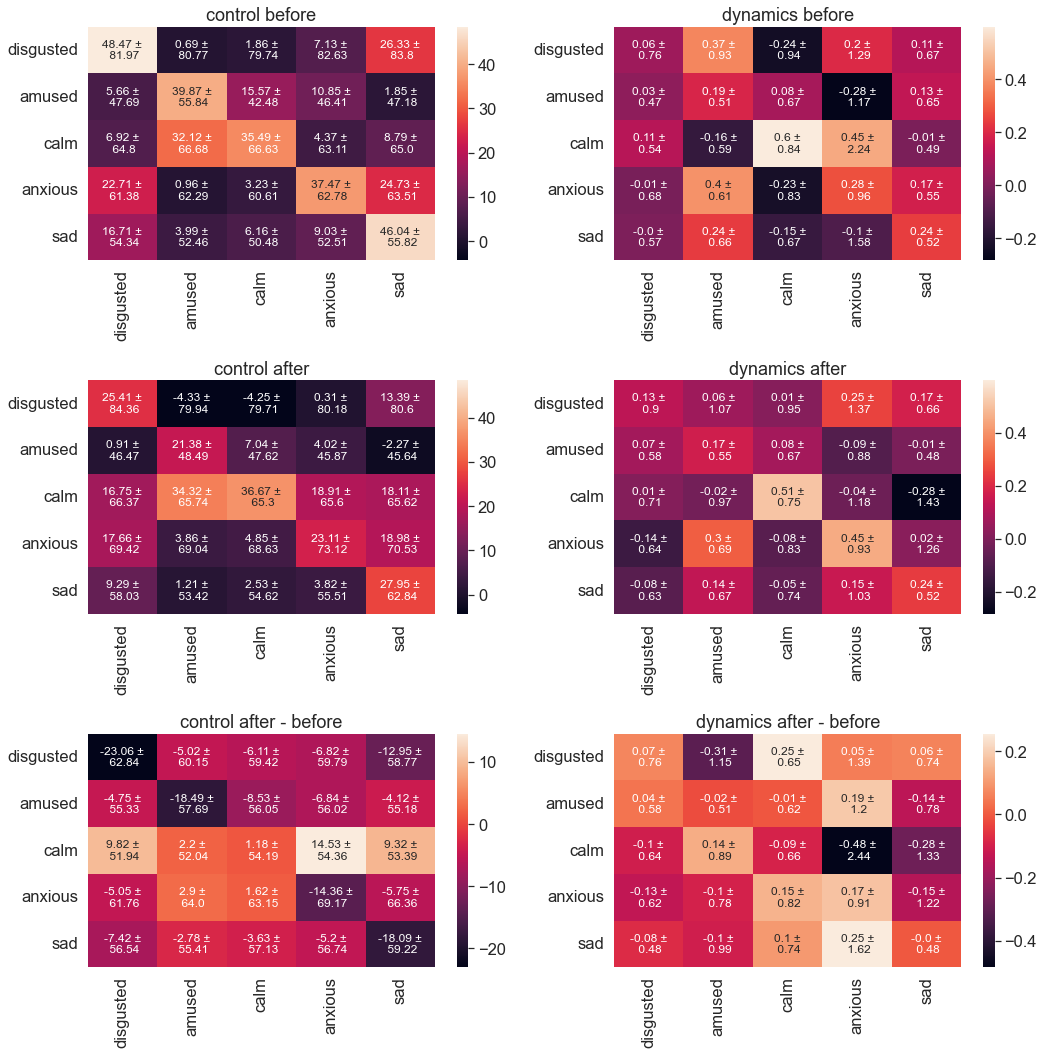

In [13]:
# average dynamics and control matrix only participants in distancing group
plot_matrices(controls, dynamics, df['randomized_condition']==1, mood_categories)

----
Dynamics and Controllability Related to Symptoms?
--

In [14]:
# Load psychological questionnaire data from GAD-7, PHQ-9 and DERS-18
df_questionnaire = pd.read_csv('../results/questionnaire_data.csv',index_col=[0])
questionnaires = ['phq', 'gad', 'ders']
df_questionnaire = df_questionnaire.drop(index=ex[0]).reset_index(drop=True)

In [15]:
# Define the timing of mood ratings, representing different time points of the experiment.
# The 'mood_dict' dictionary stores mood ratings for different time points: baseline, before intervention, after intervention, mean change, variance before intervention, and variance after intervention.
# Each mood rating is transposed (T) to match the DataFrame structure.
mood_dict = {
          'controlval_t1': controls['absval'][0,:,0], \
          'controlval_t2': controls['absval'][0,:,1], \
          'controlval_change': controls['absval'][0,:,1] - controls['absval'][0,:,0], \
          'dynamicsval_t1': dynamics['absval'][0,:,0], \
          'dynamicsval_t2': dynamics['absval'][0,:,1], \
          'dynamicsval_change': dynamics['absval'][0,:,1] - dynamics['absval'][0,:,0], \
}

df_mood = df_questionnaire.copy()
# Iterate through each entry in the 'mood_dict' dictionary.
for j in mood_dict.items():
    # Create mood-related column names with the timing label (e.g., 'baseline', 'mean_t1', etc.).
    mood_columns = [j[0]]
    
    # Create a temporary DataFrame with mood ratings for the specific timing.
    tmp = pd.DataFrame(j[1], columns=mood_columns)
    
    # Concatenate the temporary DataFrame with 'df_mood'.
    df_mood = pd.concat((df_mood, tmp), axis=1)
    
    # Z-score normalize each mood-related column in 'df_mood' to make the data comparable and standardized.
    for i in mood_columns:
        df_mood[i] = prep.zscore(df_mood[i])

In [16]:
# Define a function to run a generalized linear model (GLM)
def run_model(k, glm_formula, q, df_mood, glmstats, idx):
    # Fit the GLM model using the provided formula and data
    model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
    
    # Iterate over the specified formula variations and process results
    for g in glm_formula[1]:
        tmp = prep.convert_stats_table(model, g)
        glmstats.append([tmp.values[i] for i in stats_items])
        idx.append(tmp.name + ' -> ' + list(mood_dict.keys())[d])
    return glmstats, idx, tmp

In [17]:
# Define different GLM formula variations
formula = [[' ~ ', [1]], \
           [' ~ randomized_condition + ', [1, 2]], 
           [' ~ randomized_condition * ', [3]]]

# Specify the indices for the statistics items of interest
stats_items = [0, 3, 4, 5]

# Create an empty list to store the final statistics data
df_stats_all = []

# Loop over each z-score questionnaire
for q in [i + '_zscore' for i in questionnaires]:
    df_stats = pd.DataFrame()  # Create an empty DataFrame for statistics
    
    # Loop over 'control' and 'dynamic' conditions
    for m in ['control', 'dynamic']:
        glmstats, idx = [], []  # Create empty lists to store statistics and indices
        mood_columns = [i for i in df_mood.columns if m in i]  # Filter columns by condition
        
        # Iterate over mood columns based on their naming pattern
        for d, k in enumerate(mood_columns):
            if '1' in k: 
                glm_formula = formula[0]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
            elif '2' in k or 'change' in k: 
                glm_formula = formula[1:]
                for gg in glm_formula:
                    glmstats, idx, tmp = run_model(k, gg, q, df_mood, glmstats, idx)
            else: 
                glm_formula = [' ~ ', [1]]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
        
        # Prepare column names and combine the results into the statistics DataFrame
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m), 4), np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, pd.DataFrame(glmstats, columns=header, index=idx)), axis=1)
    
    # Apply a condition filter and formatting to the statistics, then display the DataFrame
    idx = []
    for m in ['control', 'dynamic']:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i, m in enumerate(['control', 'dynamic']):
        df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'
    display(df_stats)
    
    # Append the current statistics DataFrame to the list (commented out)
    # df_stats_all.append(df_stats)
    
    # Uncomment the following lines if you want to generate LaTeX output for a specific questionnaire
    # if q == 'ders_zscore':
    #     print(df_stats.to_latex(escape=False))


control                \
                                                      coef  P>|z| [0.025   
phq_zscore -> controlval_t1                          0.107  0.279 -0.087   
randomized_condition -> controlval_t2               -0.109  0.585 -0.500   
phq_zscore -> controlval_t2                         -0.009  0.929 -0.205   
randomized_condition:phq_zscore -> controlval_t2     0.004  0.986 -0.392   
randomized_condition -> controlval_change           -0.085  0.669 -0.474   
phq_zscore -> controlval_change                     -0.105  0.292 -0.300   
randomized_condition:phq_zscore -> controlval_c...  -0.102  0.612 -0.495   

                                                          dynamic         \
                                                   0.975]    coef  P>|z|   
phq_zscore -> controlval_t1                         0.300  -0.051  0.607   
randomized_condition -> controlval_t2               0.282   0.068  0.731   
phq_zscore -> controlval_t2                         0.187   0.089  0.371   
randomized_condition:phq_zscore -> controlval_t2    0.399  -0.256  0.200   
randomized_condition -> controlval_change           0.304   0.080  0.685   
phq_zscore -> controlval_change                     0.090   0.132  0.182   
randomized_condition:phq_zscore -> controlval_c...  0.292  -0.523  0.007   

                                                                  
                                                   [0.025 0.975]  
phq_zscore -> controlval_t1                        -0.245  0.143  
randomized_condition -> controlval_t2              -0.321  0.458  
phq_zscore -> controlval_t2                        -0.106  0.284  
randomized_condition:phq_zscore -> controlval_t2   -0.647  0.135  
randomized_condition -> controlval_change          -0.307  0.468  
phq_zscore -> controlval_change                    -0.062  0.326  
randomized_condition:phq_zscore -> controlval_c... -0.902 -0.144

control                \
                                                      coef  P>|z| [0.025   
gad_zscore -> controlval_t1                          0.142  0.145 -0.049   
randomized_condition -> controlval_t2               -0.109  0.582 -0.499   
gad_zscore -> controlval_t2                          0.024  0.804 -0.169   
randomized_condition:gad_zscore -> controlval_t2     0.038  0.846 -0.350   
randomized_condition -> controlval_change           -0.107  0.590 -0.494   
gad_zscore -> controlval_change                     -0.102  0.297 -0.295   
randomized_condition:gad_zscore -> controlval_c...  -0.104  0.599 -0.490   

                                                          dynamic         \
                                                   0.975]    coef  P>|z|   
gad_zscore -> controlval_t1                         0.332  -0.152  0.117   
randomized_condition -> controlval_t2               0.280   0.086  0.667   
gad_zscore -> controlval_t2                         0.218   0.056  0.573   
randomized_condition:gad_zscore -> controlval_t2    0.427  -0.150  0.449   
randomized_condition -> controlval_change           0.281   0.111  0.569   
gad_zscore -> controlval_change                     0.090   0.194  0.044   
randomized_condition:gad_zscore -> controlval_c...  0.283  -0.286  0.138   

                                                                  
                                                   [0.025 0.975]  
gad_zscore -> controlval_t1                        -0.342  0.038  
randomized_condition -> controlval_t2              -0.304  0.475  
gad_zscore -> controlval_t2                        -0.138  0.249  
randomized_condition:gad_zscore -> controlval_t2   -0.537  0.238  
randomized_condition -> controlval_change          -0.271  0.493  
gad_zscore -> controlval_change                     0.005  0.384  
randomized_condition:gad_zscore -> controlval_c... -0.663  0.092

control                \
                                                      coef  P>|z| [0.025   
ders_zscore -> controlval_t1                         0.008  0.934 -0.183   
randomized_condition -> controlval_t2               -0.109  0.582 -0.498   
ders_zscore -> controlval_t2                         0.064  0.511 -0.128   
randomized_condition:ders_zscore -> controlval_t2   -0.020  0.921 -0.406   
randomized_condition -> controlval_change           -0.101  0.612 -0.490   
ders_zscore -> controlval_change                     0.056  0.569 -0.136   
randomized_condition:ders_zscore -> controlval_...  -0.167  0.394 -0.552   

                                                          dynamic         \
                                                   0.975]    coef  P>|z|   
ders_zscore -> controlval_t1                        0.200   0.036  0.710   
randomized_condition -> controlval_t2               0.279   0.084  0.669   
ders_zscore -> controlval_t2                        0.256   0.094  0.336   
randomized_condition:ders_zscore -> controlval_t2   0.366  -0.110  0.573   
randomized_condition -> controlval_change           0.288   0.103  0.605   
ders_zscore -> controlval_change                    0.248   0.057  0.562   
randomized_condition:ders_zscore -> controlval_...  0.218  -0.177  0.368   

                                                                  
                                                   [0.025 0.975]  
ders_zscore -> controlval_t1                       -0.155  0.228  
randomized_condition -> controlval_t2              -0.303  0.473  
ders_zscore -> controlval_t2                       -0.097  0.286  
randomized_condition:ders_zscore -> controlval_t2  -0.495  0.274  
randomized_condition -> controlval_change          -0.286  0.492  
ders_zscore -> controlval_change                   -0.135  0.249  
randomized_condition:ders_zscore -> controlval_... -0.562  0.208

In [18]:
# Define the timing of mood ratings, representing different time points of the experiment.
# The 'mood_dict' dictionary stores mood ratings for different time points: baseline, before intervention, after intervention, mean change, variance before intervention, and variance after intervention.
# Each mood rating is transposed (T) to match the DataFrame structure.
mood_dict = {
          'controlvec_t1': controls['absvec'][:,0,:,0].T, \
          'controlvec_t2': controls['absvec'][:,0,:,1].T, \
          'controlvec_change': controls['absvec'][:,0,:,1].T - controls['absvec'][:,0,:,0].T, \
          'dynamicsvec_t1': dynamics['absvec'][:,0,:,0].T, \
          'dynamicsvec_t2': dynamics['absvec'][:,0,:,1].T, \
          'dynamicsvec_change': dynamics['absvec'][:,0,:,1].T - dynamics['absvec'][:,0,:,0].T, \

}

df_mood = df_questionnaire.copy()
# Iterate through each entry in the 'mood_dict' dictionary.
for j in mood_dict.items():
    # Create mood-related column names with the timing label (e.g., 'baseline', 'mean_t1', etc.).
    mood_columns = [i + '_' + j[0] for i in mood_categories]
    
    # Create a temporary DataFrame with mood ratings for the specific timing.
    tmp = pd.DataFrame(j[1], columns=mood_columns)
    
    # Concatenate the temporary DataFrame with 'df_mood'.
    df_mood = pd.concat((df_mood, tmp), axis=1)
    
    # Z-score normalize each mood-related column in 'df_mood' to make the data comparable and standardized.
    for i in mood_columns:
        df_mood[i] = prep.zscore(df_mood[i])


In [19]:
# Define different formula options for the generalized linear model (GLM).
# The 'formula' list contains two sub-lists, each representing a different formula for the GLM.
# The first sub-list represents a simple formula (no interaction terms), and the second sub-list represents a formula with interaction terms involving group.
formula = [
    [' ~ ', [1]],  # Simple formula without interaction
    [' ~ randomized_condition + ', [1, 2]],  # Formula involving 'randomized_condition'
    [' ~ randomized_condition * ', [3]]  # Formula with interaction involving 'randomized_condition'
]

# Define the indices of specific statistical items (coefficients) to extract from the GLM results.
stats_items = [0, 3, 4, 5]

# Initialize an empty list to store DataFrames containing GLM statistics for each questionnaire.
df_stats_all = []
adjusted_alpha = 0.05/(5*3)
# Iterate through each questionnaire (PHQ, GAD, and DERS).
for q in [i + '_zscore' for i in questionnaires]:
    # Create an empty DataFrame 'df_stats' to store the GLM statistics for the current questionnaire.
    df_stats = pd.DataFrame()
    
    # Iterate through each mood category.
    for m in mood_categories:
        glmstats, idx = [], []
        # Find mood-related column names in 'df_mood' that match the current mood category.
        mood_columns = [i for i in df_mood.columns if m in i]
        
        # Iterate through the mood-related columns for the current mood category.
        for d, k in enumerate(mood_columns):
            
            if 'baseline' in k or 't1' in k: formula_variable_specific = [formula[0]]
            else: formula_variable_specific = formula[1:]
            
            for glm_formula in formula_variable_specific:
                
                # Fit the GLM using the current mood-related column as the response variable and the questionnaire (q) as the predictor variable.
                model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()


                # Extract the specified statistical items (coefficients) from the GLM results and store them in 'glmstats'.
                for g in glm_formula[1]:
                    tmp = prep.convert_stats_table(model, g)
                    glmstats.append([tmp.values[i] for i in stats_items])
                    idx.append(tmp.name + ' -> ' + list(mood_dict.keys())[d])

        # Create appropriate column names and concatenate the GLM statistics for the current mood category to 'df_stats'.
        statscolumns = [tmp.index[i] for i in stats_items]
        header = [np.repeat(np.array(m), 4),
                  np.array(statscolumns)]
        df_stats = pd.concat((df_stats, pd.DataFrame(glmstats, columns=header, index=idx)), axis=1)
    
    # Replace p-values less than 0.001 with the string '<0.001'.
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < adjusted_alpha)
    df_stats = df_stats.round(3)
    for i, m in enumerate(mood_categories):
        df_stats.loc[idx[i], (m, 'P>|z|')] = '$<' + str(np.round(adjusted_alpha,3)) + '$'
    
    # Display the DataFrame 'df_stats' with the GLM statistics for the current questionnaire.
    display(df_stats)
    
    # Append the DataFrame 'df_stats' to the list 'df_stats_all'.
    df_stats_all.append(df_stats)
    
    # Uncomment the line below to export the DataFrame 'df_stats' as a LaTeX table.
#     print(df_stats.to_latex(escape=False))


disgusted                \
                                                        coef  P>|z| [0.025   
phq_zscore -> controlvec_t1                           -0.145   0.14 -0.338   
randomized_condition -> controlvec_t2                  0.191  0.331 -0.194   
phq_zscore -> controlvec_t2                            0.146  0.139 -0.047   
randomized_condition:phq_zscore -> controlvec_t2       0.036  0.856 -0.354   
randomized_condition -> controlvec_change              0.146  0.449 -0.232   
phq_zscore -> controlvec_change                        0.239  0.013  0.049   
randomized_condition:phq_zscore -> controlvec_c...     0.114   0.56 -0.269   
phq_zscore -> dynamicsvec_t1                          -0.056  0.569 -0.251   
randomized_condition -> dynamicsvec_t2                 0.167    0.4 -0.222   
phq_zscore -> dynamicsvec_t2                           0.062   0.53 -0.132   
randomized_condition:phq_zscore -> dynamicsvec_t2      0.410  0.037  0.024   
randomized_condition -> dynamicsvec_change             0.284   0.15 -0.103   
phq_zscore -> dynamicsvec_change                       0.074  0.453 -0.119   
randomized_condition:phq_zscore -> dynamicsvec_...     0.322  0.102 -0.064   

                                                          amused         \
                                                   0.975]   coef  P>|z|   
phq_zscore -> controlvec_t1                         0.047  0.133  0.175   
randomized_condition -> controlvec_t2               0.576 -0.149  0.454   
phq_zscore -> controlvec_t2                         0.339  0.046  0.644   
randomized_condition:phq_zscore -> controlvec_t2    0.426 -0.076  0.705   
randomized_condition -> controlvec_change           0.525 -0.290  0.142   
phq_zscore -> controlvec_change                     0.429 -0.057  0.562   
randomized_condition:phq_zscore -> controlvec_c...  0.497 -0.194   0.33   
phq_zscore -> dynamicsvec_t1                        0.138 -0.026  0.797   
randomized_condition -> dynamicsvec_t2              0.556 -0.184  0.355   
phq_zscore -> dynamicsvec_t2                        0.258  0.082  0.408   
randomized_condition:phq_zscore -> dynamicsvec_t2   0.796  0.028  0.888   
randomized_condition -> dynamicsvec_change          0.670 -0.194  0.326   
phq_zscore -> dynamicsvec_change                    0.268  0.086  0.388   
randomized_condition:phq_zscore -> dynamicsvec_...  0.708  0.166  0.406   

                                                                   calm  \
                                                   [0.025 0.975]   coef   
phq_zscore -> controlvec_t1                        -0.059  0.326 -0.032   
randomized_condition -> controlvec_t2              -0.539  0.241 -0.160   
phq_zscore -> controlvec_t2                        -0.149  0.242 -0.032   
randomized_condition:phq_zscore -> controlvec_t2   -0.471  0.319 -0.241   
randomized_condition -> controlvec_change          -0.676  0.097 -0.114   
phq_zscore -> controlvec_change                    -0.251  0.136 -0.007   
randomized_condition:phq_zscore -> controlvec_c... -0.583  0.196 -0.193   
phq_zscore -> dynamicsvec_t1                       -0.220  0.169 -0.091   
randomized_condition -> dynamicsvec_t2             -0.572  0.205 -0.055   
phq_zscore -> dynamicsvec_t2                       -0.113  0.277  0.101   
randomized_condition:phq_zscore -> dynamicsvec_t2  -0.365  0.422 -0.585   
randomized_condition -> dynamicsvec_change         -0.583  0.194 -0.177   
phq_zscore -> dynamicsvec_change                   -0.109  0.280  0.155   
randomized_condition:phq_zscore -> dynamicsvec_... -0.226  0.558 -0.378   

                                                                            \
                                                       P>|z| [0.025 0.975]   
phq_zscore -> controlvec_t1                            0.751 -0.226  0.163   
randomized_condition -> controlvec_t2                   0.42 -0.550  0.229   
phq_zscore -> controlvec_t2                            0.748 -0.227  0.163   
randomized

disgusted                \
                                                        coef  P>|z| [0.025   
gad_zscore -> controlvec_t1                           -0.090  0.356 -0.282   
randomized_condition -> controlvec_t2                  0.219  0.265 -0.167   
gad_zscore -> controlvec_t2                            0.098  0.314 -0.093   
randomized_condition:gad_zscore -> controlvec_t2      -0.015  0.941 -0.400   
randomized_condition -> controlvec_change              0.192  0.326 -0.191   
gad_zscore -> controlvec_change                        0.155   0.11 -0.035   
randomized_condition:gad_zscore -> controlvec_c...     0.005  0.979 -0.378   
gad_zscore -> dynamicsvec_t1                          -0.006  0.952 -0.198   
randomized_condition -> dynamicsvec_t2                 0.183  0.351 -0.202   
gad_zscore -> dynamicsvec_t2                           0.127  0.193 -0.064   
randomized_condition:gad_zscore -> dynamicsvec_t2      0.436  0.023  0.061   
randomized_condition -> dynamicsvec_change             0.300  0.126 -0.084   
gad_zscore -> dynamicsvec_change                       0.093   0.34 -0.098   
randomized_condition:gad_zscore -> dynamicsvec_...     0.387  0.044  0.011   

                                                          amused         \
                                                   0.975]   coef  P>|z|   
gad_zscore -> controlvec_t1                         0.101  0.088  0.367   
randomized_condition -> controlvec_t2               0.605 -0.137  0.489   
gad_zscore -> controlvec_t2                         0.290  0.094   0.34   
randomized_condition:gad_zscore -> controlvec_t2    0.371  0.234  0.233   
randomized_condition -> controlvec_change           0.576 -0.298   0.13   
gad_zscore -> controlvec_change                     0.345  0.010  0.922   
randomized_condition:gad_zscore -> controlvec_c...  0.388  0.102  0.604   
gad_zscore -> dynamicsvec_t1                        0.187  0.065  0.505   
randomized_condition -> dynamicsvec_t2              0.569 -0.165  0.402   
gad_zscore -> dynamicsvec_t2                        0.318  0.102  0.295   
randomized_condition:gad_zscore -> dynamicsvec_t2   0.811  0.076  0.699   
randomized_condition -> dynamicsvec_change          0.684 -0.179  0.366   
gad_zscore -> dynamicsvec_change                    0.283  0.032  0.747   
randomized_condition:gad_zscore -> dynamicsvec_...  0.763  0.051  0.797   

                                                                   calm  \
                                                   [0.025 0.975]   coef   
gad_zscore -> controlvec_t1                        -0.104  0.280 -0.063   
randomized_condition -> controlvec_t2              -0.524  0.251 -0.166   
gad_zscore -> controlvec_t2                        -0.099  0.286 -0.017   
randomized_condition:gad_zscore -> controlvec_t2   -0.150  0.618 -0.106   
randomized_condition -> controlvec_change          -0.684  0.087 -0.114   
gad_zscore -> controlvec_change                    -0.182  0.201  0.030   
randomized_condition:gad_zscore -> controlvec_c... -0.283  0.487 -0.035   
gad_zscore -> dynamicsvec_t1                       -0.127  0.257 -0.167   
randomized_condition -> dynamicsvec_t2             -0.552  0.222 -0.036   
gad_zscore -> dynamicsvec_t2                       -0.089  0.294  0.061   
randomized_condition:gad_zscore -> dynamicsvec_t2  -0.310  0.462 -0.440   
randomized_condition -> dynamicsvec_change         -0.568  0.209 -0.143   
gad_zscore -> dynamicsvec_change                   -0.161  0.224  0.179   
randomized_condition:gad_zscore -> dynamicsvec_... -0.337  0.439 -0.108   

                                                                         \
                                                    P>|z| [0.025 0.975]   
gad_zscore -> controlvec_t1                         0.522 -0.255  0.129   
randomized_condition -> controlvec_t2               0.402 -0.555  0.222   
gad_zscore -> controlvec_t2                         0.863 -0.210  0.176   
randomized_condition:gad_

disgusted                \
                                                        coef  P>|z| [0.025   
ders_zscore -> controlvec_t1                          -0.005  0.962 -0.196   
randomized_condition -> controlvec_t2                  0.217  0.267 -0.167   
ders_zscore -> controlvec_t2                           0.141  0.144 -0.048   
randomized_condition:ders_zscore -> controlvec_t2     -0.055  0.778 -0.436   
randomized_condition -> controlvec_change              0.187  0.341 -0.198   
ders_zscore -> controlvec_change                       0.119  0.219 -0.071   
randomized_condition:ders_zscore -> controlvec_...     0.082  0.675 -0.301   
ders_zscore -> dynamicsvec_t1                         -0.030  0.761 -0.221   
randomized_condition -> dynamicsvec_t2                 0.180  0.359 -0.205   
ders_zscore -> dynamicsvec_t2                          0.143  0.139 -0.046   
randomized_condition:ders_zscore -> dynamicsvec_t2     0.241  0.213 -0.138   
randomized_condition -> dynamicsvec_change             0.298  0.128 -0.085   
ders_zscore -> dynamicsvec_change                      0.119  0.218 -0.070   
randomized_condition:ders_zscore -> dynamicsvec...     0.388  0.041  0.016   

                                                          amused         \
                                                   0.975]   coef  P>|z|   
ders_zscore -> controlvec_t1                        0.187  0.084  0.388   
randomized_condition -> controlvec_t2               0.601 -0.141  0.477   
ders_zscore -> controlvec_t2                        0.331  0.005  0.959   
randomized_condition:ders_zscore -> controlvec_t2   0.326  0.274  0.161   
randomized_condition -> controlvec_change           0.573 -0.300  0.127   
ders_zscore -> controlvec_change                    0.310 -0.062  0.525   
randomized_condition:ders_zscore -> controlvec_...  0.464  0.057   0.77   
ders_zscore -> dynamicsvec_t1                       0.162 -0.073  0.453   
randomized_condition -> dynamicsvec_t2              0.564 -0.171  0.388   
ders_zscore -> dynamicsvec_t2                       0.333 -0.049  0.615   
randomized_condition:ders_zscore -> dynamicsvec_t2  0.620  0.238  0.222   
randomized_condition -> dynamicsvec_change          0.681 -0.180  0.363   
ders_zscore -> dynamicsvec_change                   0.308  0.015  0.875   
randomized_condition:ders_zscore -> dynamicsvec...  0.761  0.250  0.201   

                                                                   calm  \
                                                   [0.025 0.975]   coef   
ders_zscore -> controlvec_t1                       -0.107  0.275 -0.089   
randomized_condition -> controlvec_t2              -0.530  0.248 -0.167   
ders_zscore -> controlvec_t2                       -0.187  0.197 -0.059   
randomized_condition:ders_zscore -> controlvec_t2  -0.109  0.656 -0.085   
randomized_condition -> controlvec_change          -0.685  0.085 -0.115   
ders_zscore -> controlvec_change                   -0.252  0.128  0.011   
randomized_condition:ders_zscore -> controlvec_... -0.325  0.439  0.011   
ders_zscore -> dynamicsvec_t1                      -0.264  0.118 -0.146   
randomized_condition -> dynamicsvec_t2             -0.559  0.217 -0.038   
ders_zscore -> dynamicsvec_t2                      -0.241  0.142  0.038   
randomized_condition:ders_zscore -> dynamicsvec_t2 -0.144  0.621 -0.306   
randomized_condition -> dynamicsvec_change         -0.569  0.208 -0.149   
ders_zscore -> dynamicsvec_change                  -0.176  0.207  0.146   
randomized_condition:ders_zscore -> dynamicsvec... -0.133  0.632 -0.386   

                                                                         \
                                                    P>|z| [0.025 0.975]   
ders_zscore -> controlvec_t1                         0.36 -0.280  0.102   
randomized_condition -> controlvec_t2                 0.4 -0.555  0.221   
ders_zscore -> controlvec_t2                        0.545 -0.251  0.132   
randomized_condition:ders

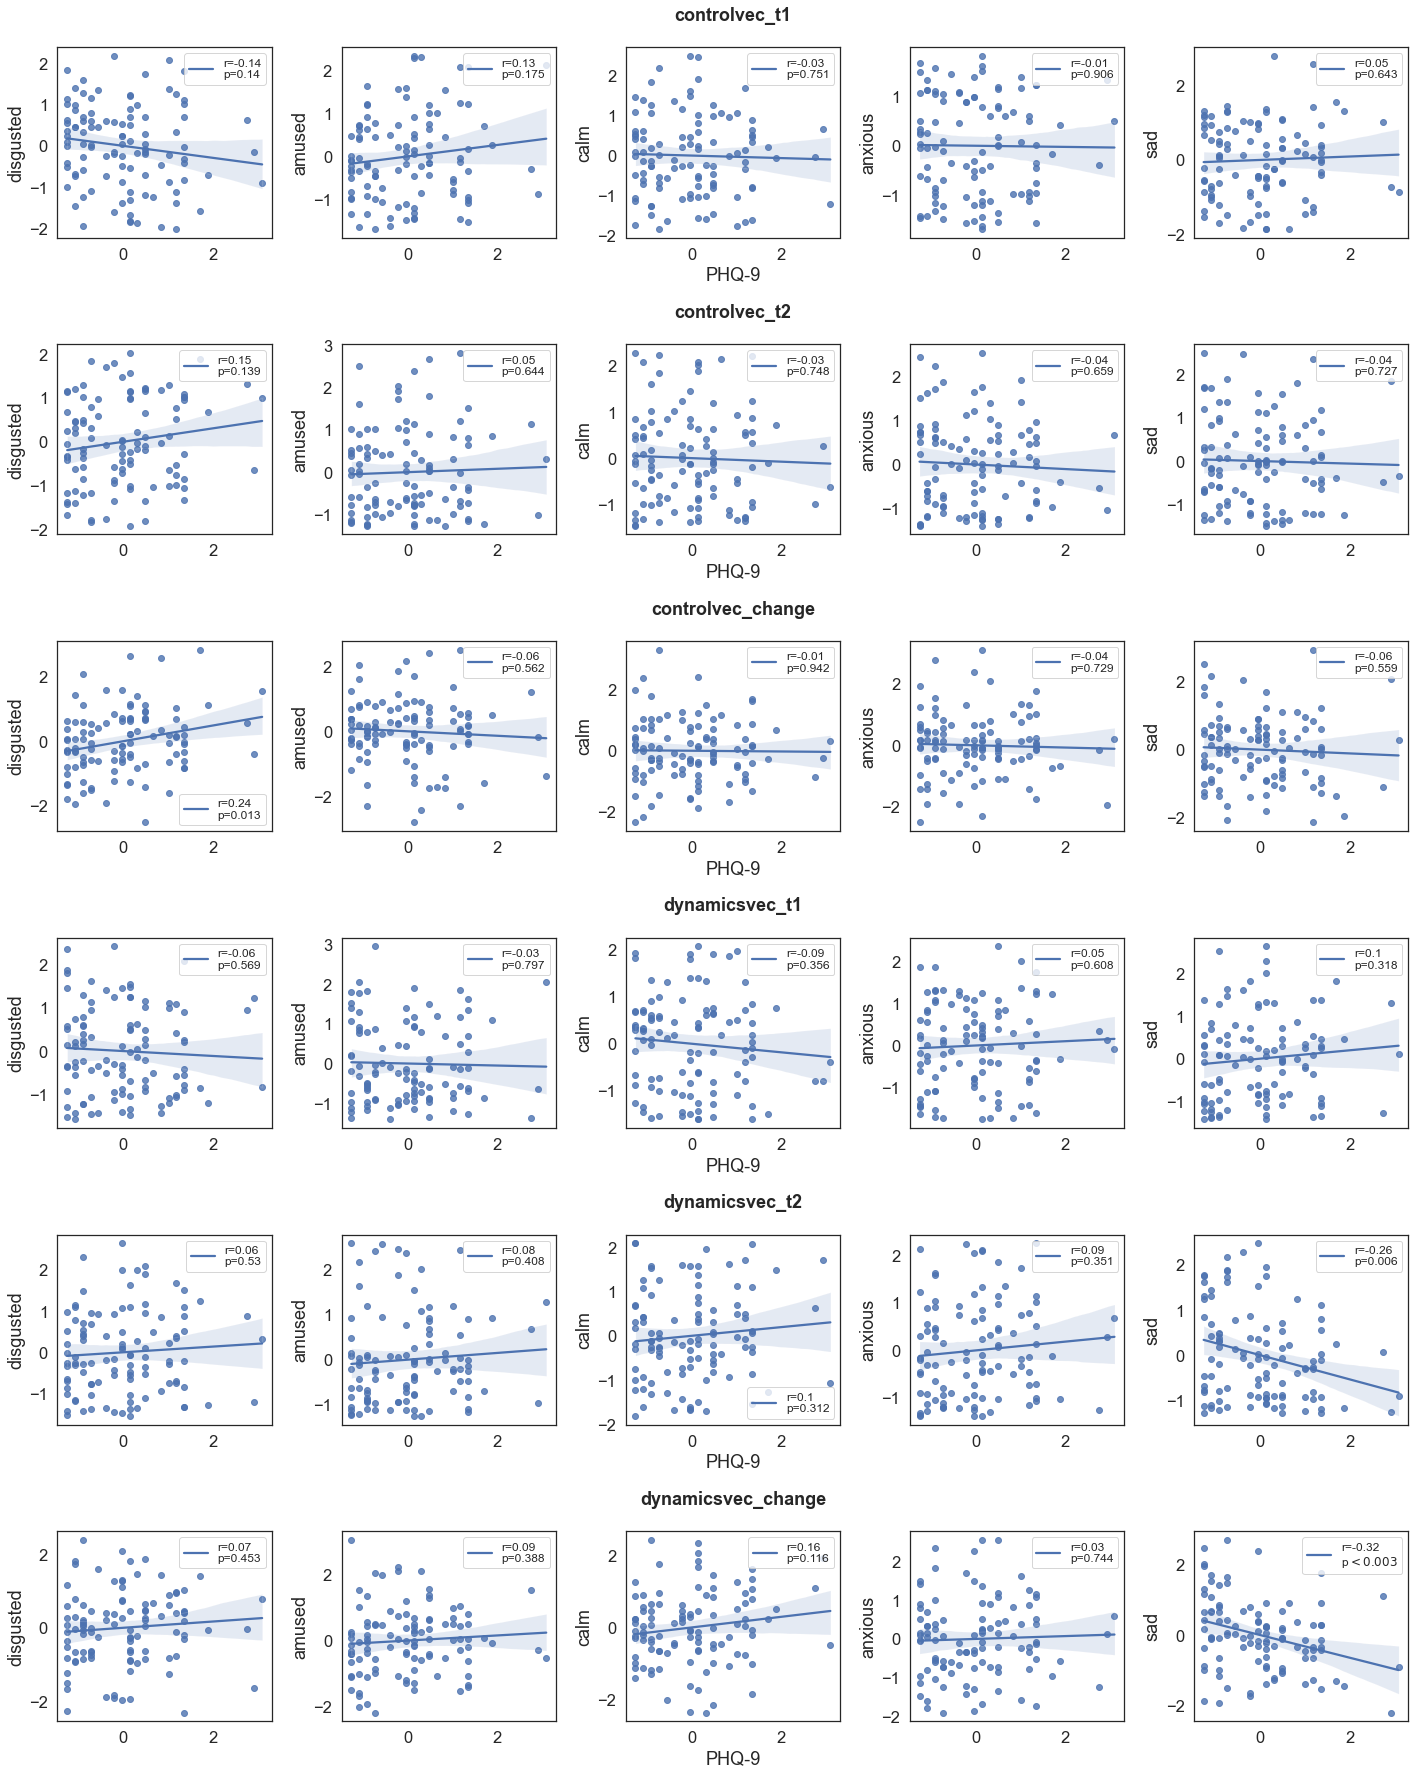

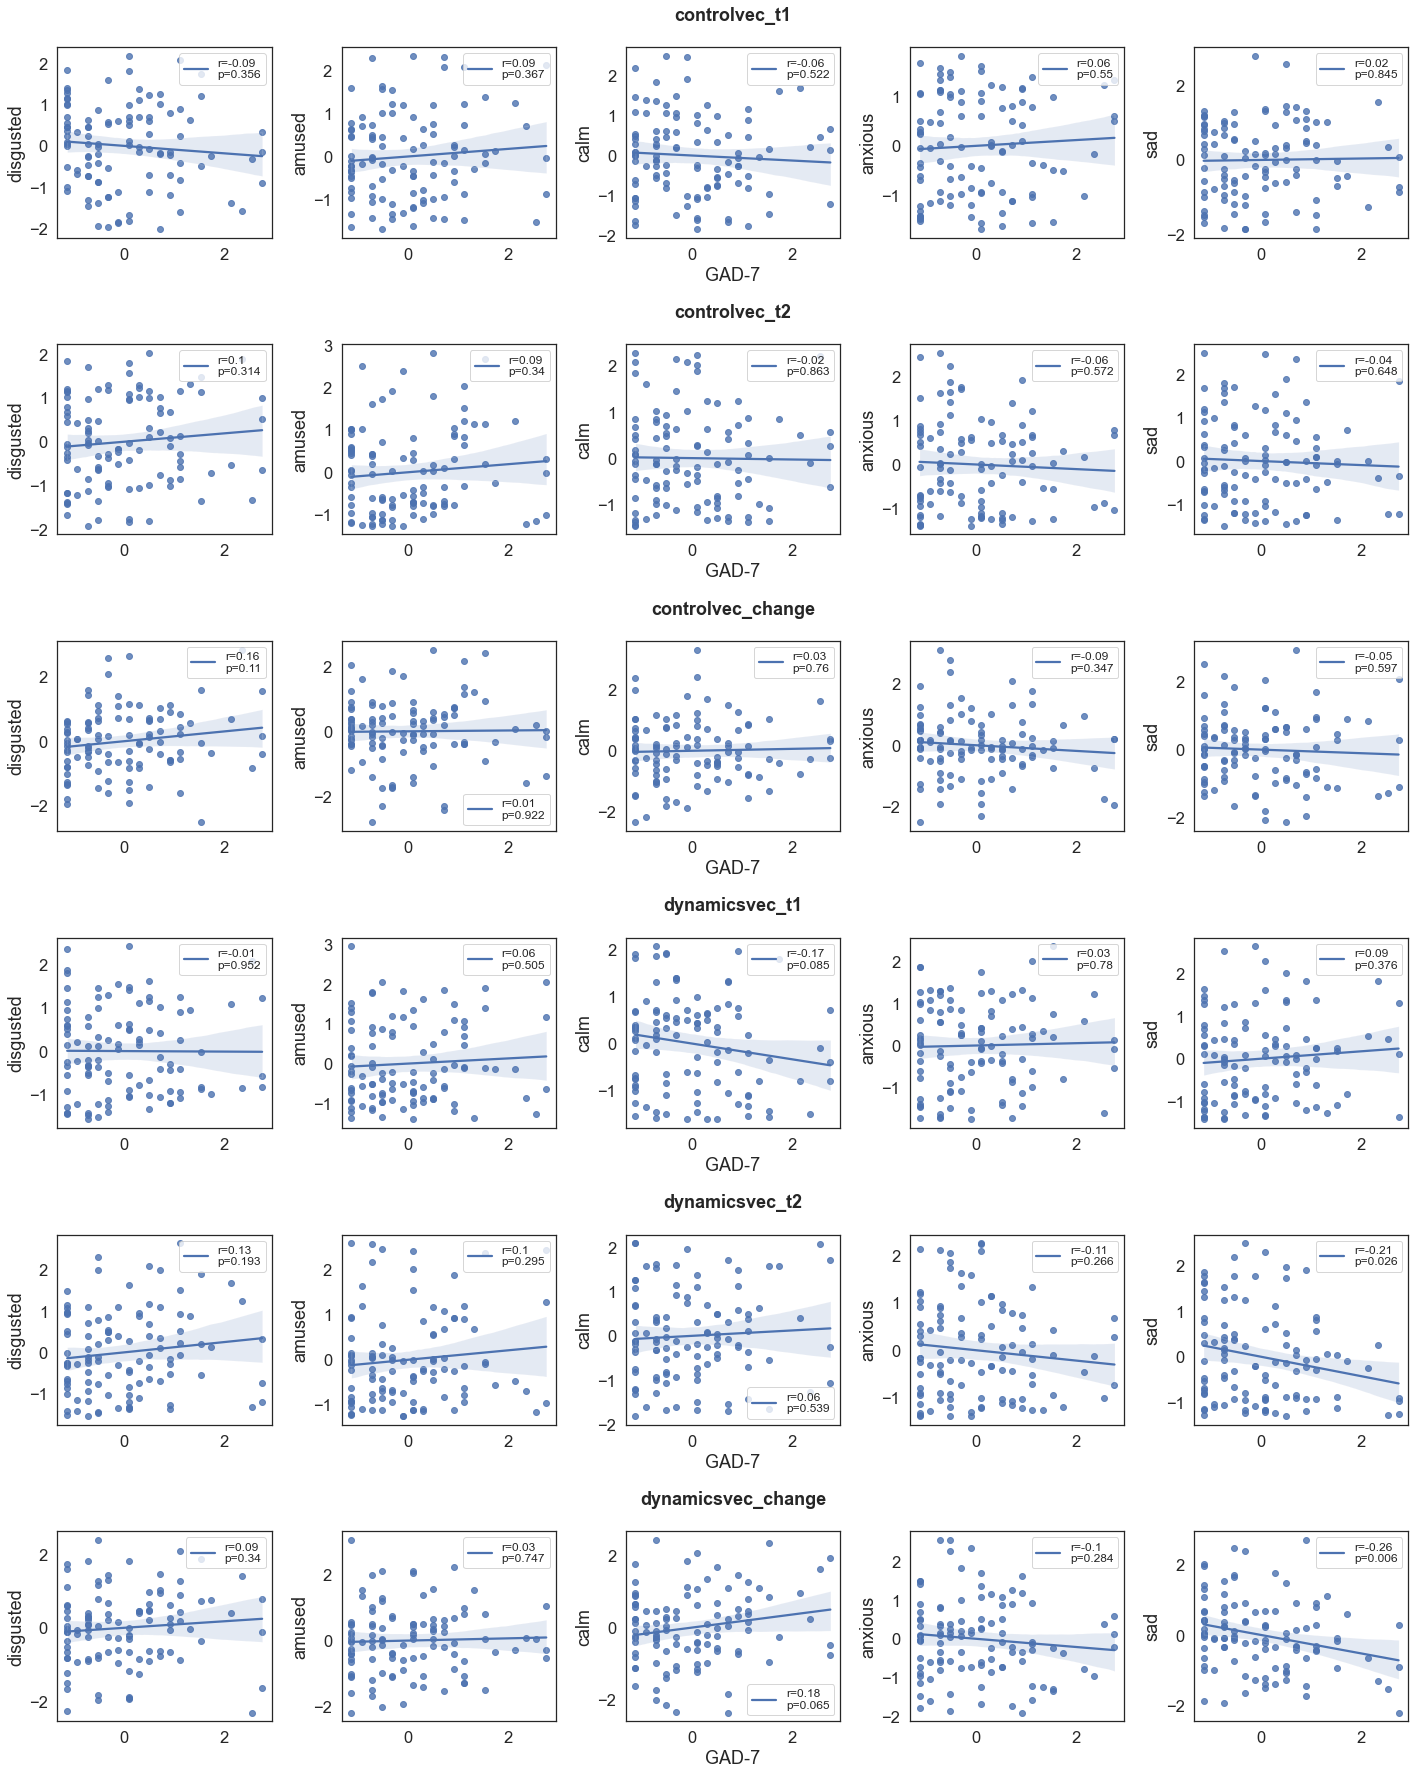

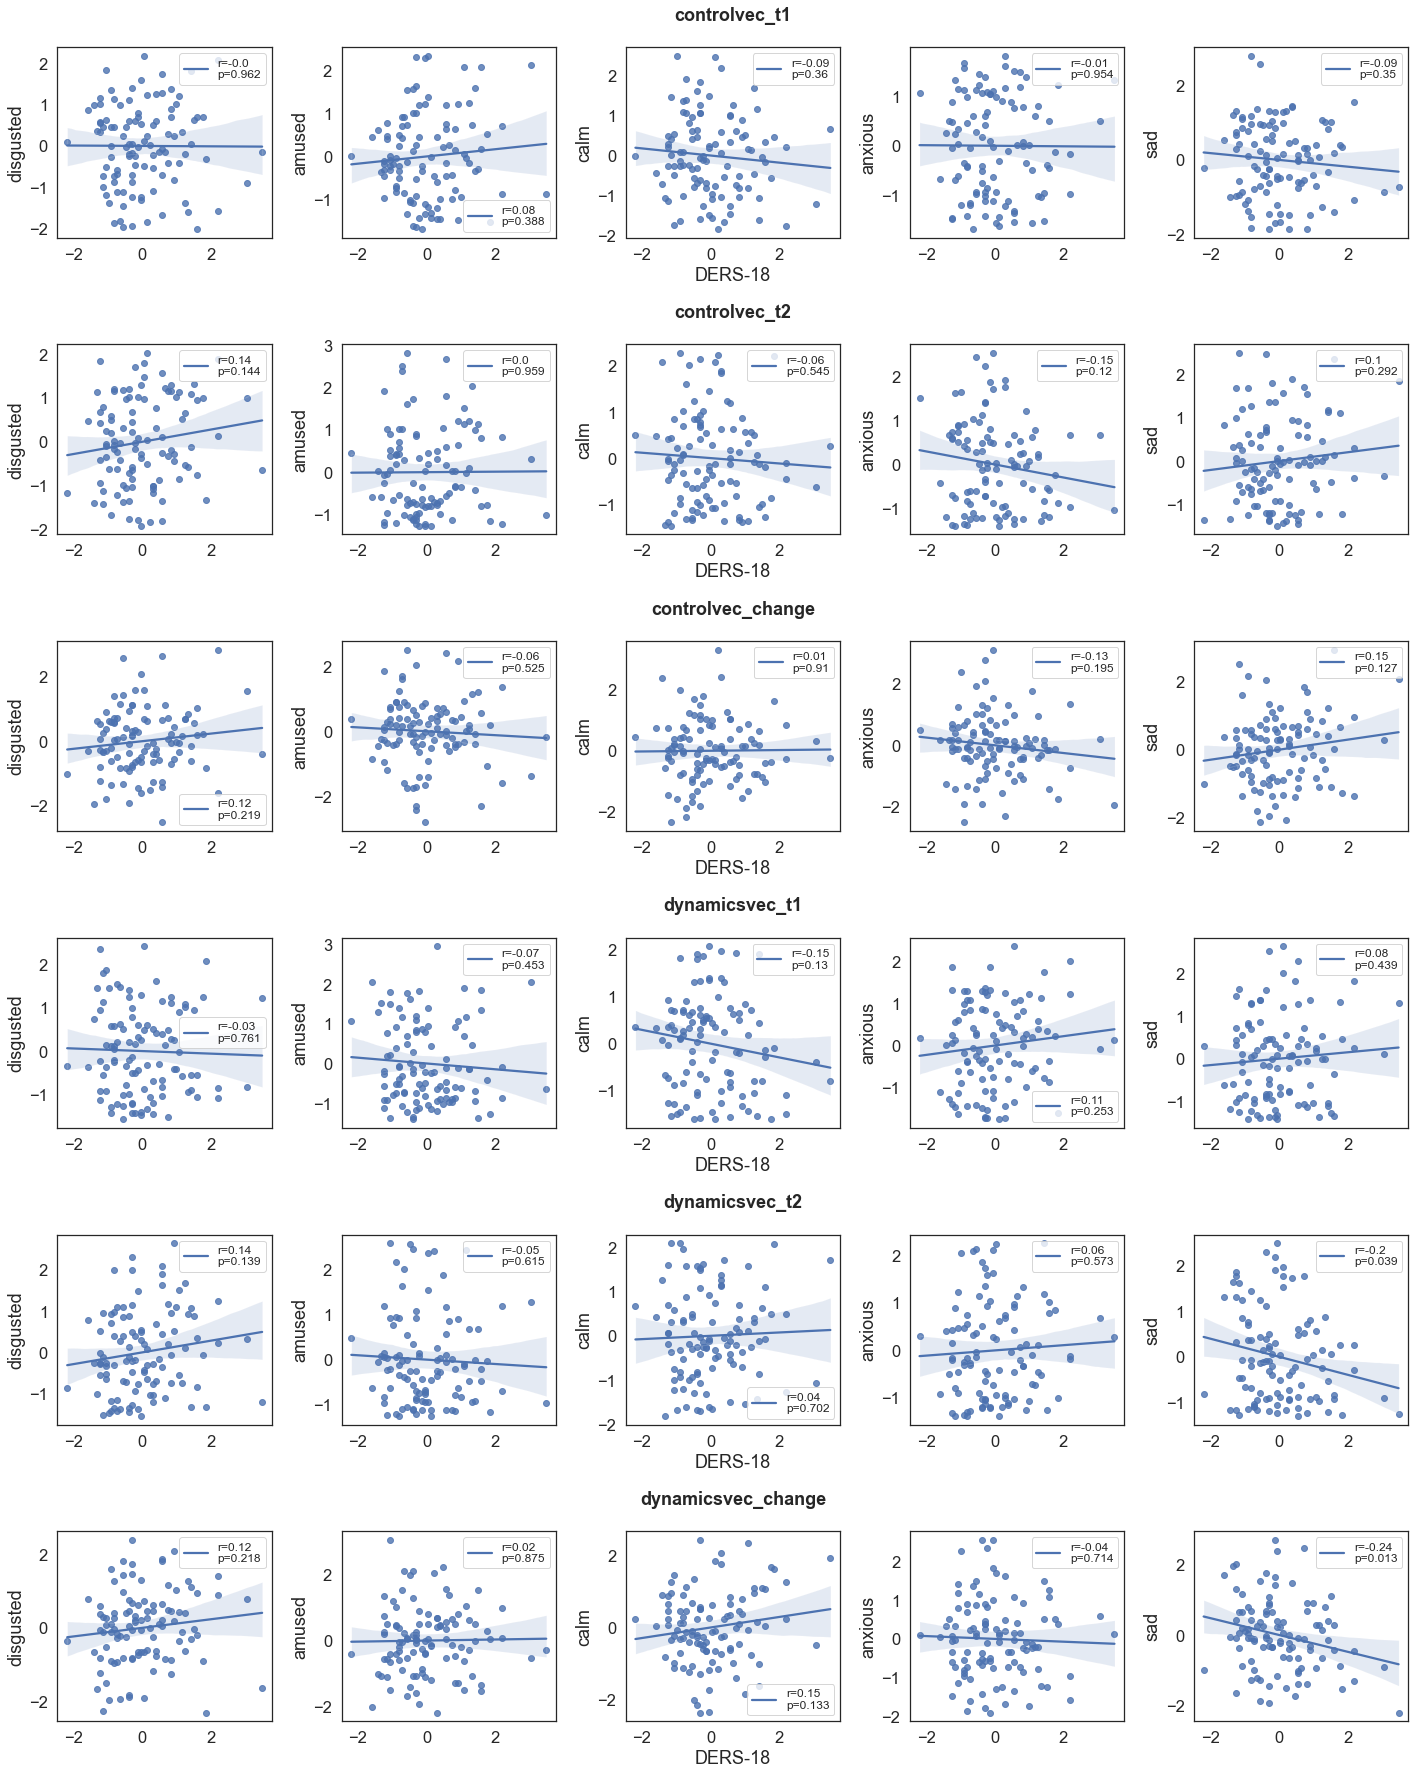

In [20]:
# List of labels for the questionnaires used in the plots
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']

# Loop through the questionnaires and their corresponding z-scored data
for r, q in enumerate([i + '_zscore' for i in questionnaires]):
    # Create a new figure and a grid of subplots based on the number of timing conditions and mood categories
    fig, axs = plt.subplots(len(mood_dict), len(mood_categories), figsize=(20, 25))
    grid = plt.GridSpec(len(mood_dict), len(mood_categories))
    
    # Loop through each timing condition (baseline, mean_t1, mean_t2, etc.)
    for m, t in enumerate(mood_dict.keys()):
        # Find the mood-related column names for the current timing condition
        c = [i for i in df_mood.columns if t in i]
        
        # Loop through each mood-related column for the current timing condition
        for n, cc in enumerate(c):
            # Get the regression slope and p-value from the statistics DataFrame for the current questionnaire and timing condition
            slope = df_stats_all[r][(mood_categories[n], 'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n], 'P>|z|')].loc[q + ' -> ' + t]
            
            # If the p-value is not already a string, format it as a string with three decimal places
            if not (type(p_value) == str):
                p_value = '=' + str(np.round(p_value, 3))
            
            # Create a regression plot for the current questionnaire and mood category
            b = sns.regplot(data=df_mood, x=q, y=cc, ax=axs[m, n], \
                            line_kws={'label': 'r=' + str(np.round(slope, 2)) + '\np' + p_value})
            
            # Add a legend to the plot with font size 12
            b.legend(prop={'size': 12})
            
            # Set x-axis and y-axis labels for the subplot
            if n == 2:
                b.set(xlabel=questionnaire_label[r])  # Set the x-axis label for the last row of subplots (timing labels)
            else:
                b.set(xlabel='')  # Remove the x-axis label for other rows of subplots
            
            b.set(ylabel=mood_categories[n])  # Set the y-axis label for each subplot (mood categories)
            
        # Uncomment the line below to add a subtitle above each set of subplots (commented in the original code).
        aux.create_subtitle(fig, grid[m, ::], list(mood_dict.keys())[m])
    
    # Adjust the layout of the subplots to avoid overlapping
    fig.tight_layout()